In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_json("/content/drive/MyDrive/Colab_Notebooks/Case_Studies/amazon_recommander_system/tops_fashion.json")

In [ ]:
print("no of datapoints :",data.shape[0])
print("no of features :",data.shape[1])

no of datapoints : 183138
no of features : 19


In [ ]:
#print column
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

In [ ]:
#out of 19 features we use only 6 features
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [ ]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head() # prints the top rows in the table.

Number of data points :  183138 Number of features: 7


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


<h2>Missing data for various features

In [ ]:
#basic stats for feature:product_type_name
print(data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [ ]:
# names of different product types
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [ ]:
#10 most frequent product_type_name
from collections import Counter
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

####  Basic stats for the feature: brand

In [ ]:
# there are 10577 unique brands
print(data['brand'].describe())

# 183138 - 182987 = 151 missing values.

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [ ]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

####  Basic stats for the feature: color

In [ ]:

print(data['color'].describe())

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [ ]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

####  Basic stats for the feature: formatted_price

In [ ]:
print(data['formatted_price'].describe())

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [ ]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

#### Basic stats for the feature: title


In [ ]:
print(data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [ ]:
import pickle
data.to_pickle('/content/drive/MyDrive/Colab_Notebooks/Case_Studies/amazon_recommander_system/pickle/180k_apparel_data')

In [ ]:
#get not null data
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 28395


In [ ]:
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating color=NULL : 28385


In [ ]:
#store new data in pickle fie
data.to_pickle('/content/drive/MyDrive/Colab_Notebooks/Case_Studies/amazon_recommander_system/pickle/28k_apparel_data')

<h1>Remove near duplicate items

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/Colab_Notebooks/Case_Studies/amazon_recommander_system/pickle/28k_apparel_data')
#no of duplicate items
print(sum(data.duplicated('title')))


2325


In [ ]:
data.shape[0]

28385

In [ ]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x : len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [ ]:
# Sort the whole data based on title (alphabetical order of title) 

data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


#### Some examples of dupliacte titles that differ only in the last few words.

<pre>
Titles 1:
16. woman's place is in the house and the senate shirts for Womens XXL White
17. woman's place is in the house and the senate shirts for Womens M Grey

Title 2:
25. tokidoki The Queen of Diamonds Women's Shirt X-Large
26. tokidoki The Queen of Diamonds Women's Shirt Small
27. tokidoki The Queen of Diamonds Women's Shirt Large

Title 3:
61. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
62. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
63. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
64. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
</pre>

In [ ]:
indices = []
for i , row in data_sorted.iterrows():
  indices.append(i)

In [ ]:
import itertools
stage1_dedupe_asins =[]
i=0
j=0
num_data_points = data_sorted.shape[0]

while i<num_data_points and j<num_data_points:
  previous_i=i

  a = data['title'].loc[indices[i]].split()

  j = i+1
  while j<num_data_points:

    b = data['title'].loc[indices[j]].split()
    length = max(len(a), len(b))
    count  = 0

    # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
    # example: a =['a', 'b', 'c', 'd']
    # b = ['a', 'b', 'd']
    # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
    for k in itertools.zip_longest(a,b): 
        if (k[0] == k[1]):
            count += 1

    # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
    # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
    if (length - count) > 2: # number of words in which both sensences differ
        # if both strings are differ by more than 2 words we include the 1st string index
        stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])


        # start searching for similar apperals corresponds 2nd string
        i = j
        break 
    else:
        j += 1
  if previous_i == i:
    break

           






In [ ]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

In [ ]:
print('Number of data points : ', data.shape[0])

Number of data points :  17592


In [ ]:
data.to_pickle('/content/drive/MyDrive/Colab_Notebooks/Case_Studies/amazon_recommander_system/pickle/17k_apperal_data')

#### [5.2.3] Remove duplicates : Part 2

<pre>

In the previous cell, we sorted whole data in alphabetical order of  titles.Then, we removed titles which are adjacent and very similar title

But there are some products whose titles are not adjacent but very similar.

Examples:

Titles-1
86261.  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
115042. UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

TItles-2
75004.  EVALY Women's Cool University Of UTAH 3/4 Sleeve Raglan Tee
109225. EVALY Women's Unique University Of UTAH 3/4 Sleeve Raglan Tees
120832. EVALY Women's New University Of UTAH 3/4-Sleeve Raglan Tshirt

</pre>

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/Colab_Notebooks/Case_Studies/amazon_recommander_system/pickle/17k_apperal_data')

In [ ]:
# This code snippet takes significant amount of time.
# O(n^2) time.
# Takes about an hour to run on a decent computer.

indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

<h1>Text_preprocessing

In [2]:
data = pd.read_pickle('/content/drive/MyDrive/Colab_Notebooks/Case_Studies/amazon_recommander_system/pickle/16k_apperal_data')

In [5]:
import nltk
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print("list of stop words",stop_words)

list of stop words {'will', 've', "it's", "hadn't", 'then', 're', 'until', 'an', 'aren', 'll', 'his', 'for', 'no', 'doesn', 'my', 'here', 'these', 'in', 'same', 'd', 'those', "hasn't", "she's", 'weren', 'now', 'own', 'does', 'after', 'nor', 'but', 'how', 'at', 'hadn', 'what', 'whom', 'any', 'by', 'needn', 'or', 'yourselves', "you'll", 'hasn', "that'll", 'off', 'her', 'm', 'mightn', 'ain', 'did', 'against', "don't", 'myself', 'mustn', "wasn't", 'through', 'it', 'with', 'from', 't', 'shouldn', 'about', 'as', 'out', 'can', 'who', 'doing', 'has', "doesn't", 'ours', 'ma', "isn't", 'on', 'between', 'its', 'itself', 'other', "wouldn't", 'few', 'didn', 'she', 'couldn', 'you', 'be', 'over', 'where', 'when', 'too', 'he', 'very', 'y', 'so', 'not', 'down', 'your', "you're", 'each', 'because', 's', 'before', 'both', 'most', 'there', 'don', 'our', 'below', "weren't", 'we', 'me', 'should', 'ourselves', "you'd", 'the', 'all', 'herself', 'yourself', 'i', "mightn't", "didn't", "haven't", 'again', 'while

In [7]:
def nlp_preprocessing(total_text,index,column):
  if type(total_text)is not int:
     string =""
     for words in total_text.split():

       #remove special character
       word = ("".join(e for e in words if e.isalnum()))
       #convert al letters to lower case
       word = word.lower()
       #remove stopwords
       if not word in stop_words:
         string += word+" "
     data[column][index]=string
     

In [9]:
import time
start_time = time.clock()
for index,row in data.iterrows():
  nlp_preprocessing(row['title'],index,'title')
print(time.clock()-start_time,"seconds")


4.090078999999999 seconds


In [10]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics worl...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [11]:
data.to_pickle('/content/drive/MyDrive/Colab_Notebooks/Case_Studies/amazon_recommander_system/pickle/16k_apperal_data_preprocessed')

# Text Based product similarity

In [6]:
data = pd.read_pickle('/content/drive/MyDrive/Colab_Notebooks/Case_Studies/amazon_recommander_system/pickle/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics worl...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [9]:
# Utility Functions which we will use through the rest of the workshop.


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

<h1>Bag of words model on product title

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(16042, 12609)

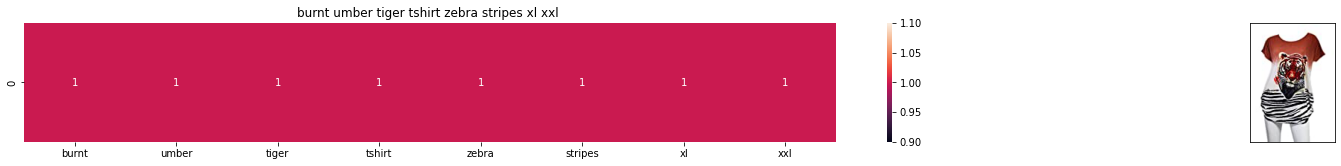

ASIN : B00JXQB5FQ
Brand: Si Row
Title: burnt umber tiger tshirt zebra stripes xl xxl 
Euclidean similarity with the query image : 0.0


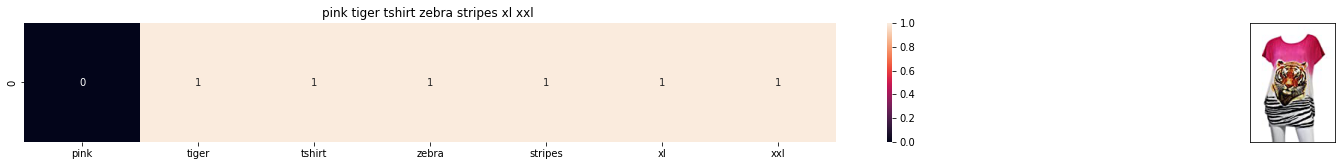

ASIN : B00JXQASS6
Brand: Si Row
Title: pink tiger tshirt zebra stripes xl xxl 
Euclidean similarity with the query image : 1.7320508075688772


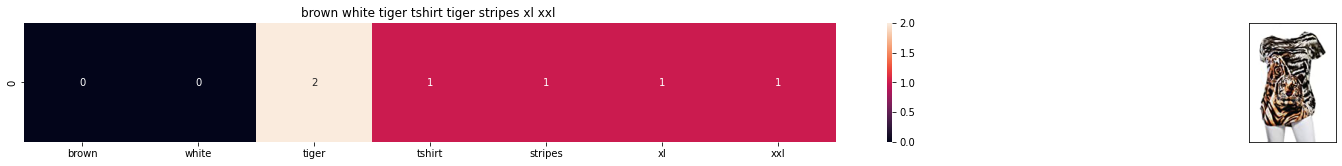

ASIN : B00JXQCWTO
Brand: Si Row
Title: brown white tiger tshirt tiger stripes xl xxl 
Euclidean similarity with the query image : 2.449489742783178


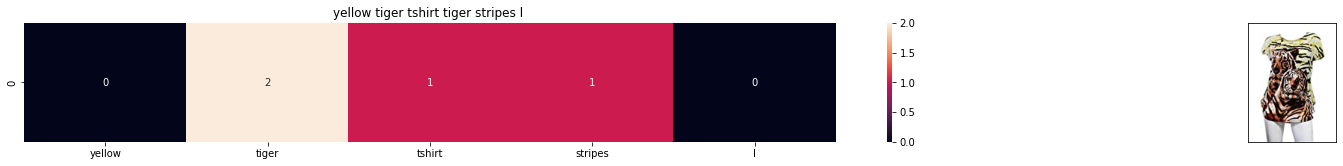

ASIN : B00JXQCUIC
Brand: Si Row
Title: yellow tiger tshirt tiger stripes l 
Euclidean similarity with the query image : 2.6457513110645907


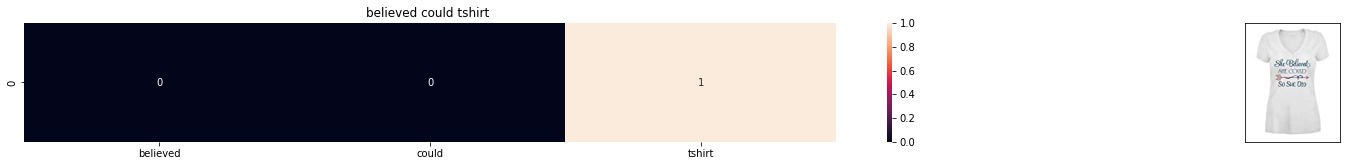

ASIN : B07568NZX4
Brand: Rustic Grace
Title: believed could tshirt 
Euclidean similarity with the query image : 3.0


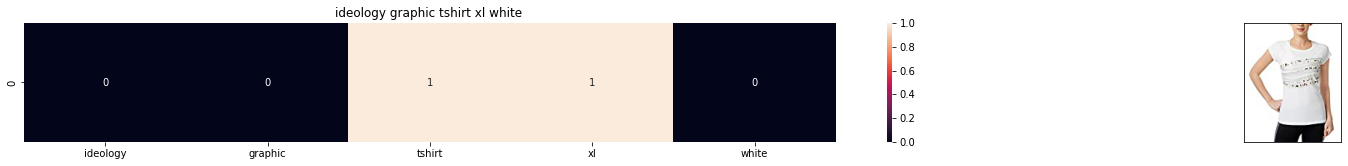

ASIN : B01NB0NKRO
Brand: Ideology
Title: ideology graphic tshirt xl white 
Euclidean similarity with the query image : 3.0


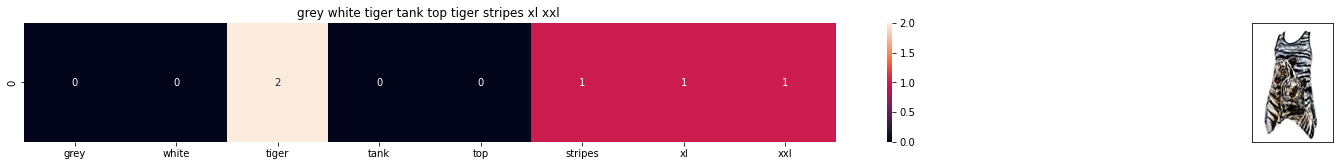

ASIN : B00JXQAFZ2
Brand: Si Row
Title: grey white tiger tank top tiger stripes xl xxl 
Euclidean similarity with the query image : 3.0


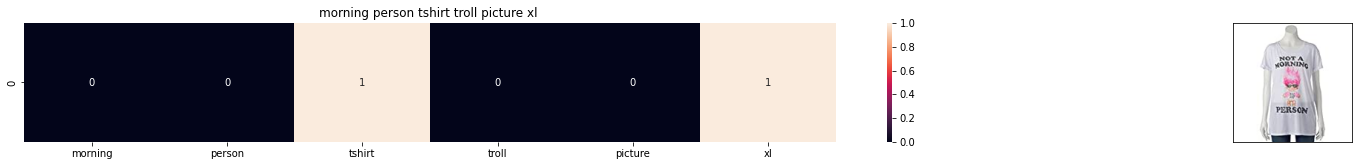

ASIN : B01CLS8LMW
Brand: Awake
Title: morning person tshirt troll picture xl 
Euclidean similarity with the query image : 3.1622776601683795


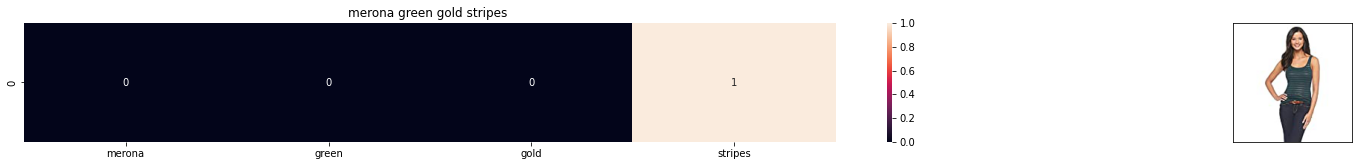

ASIN : B01KVZUB6G
Brand: Merona
Title: merona green gold stripes 
Euclidean similarity with the query image : 3.1622776601683795


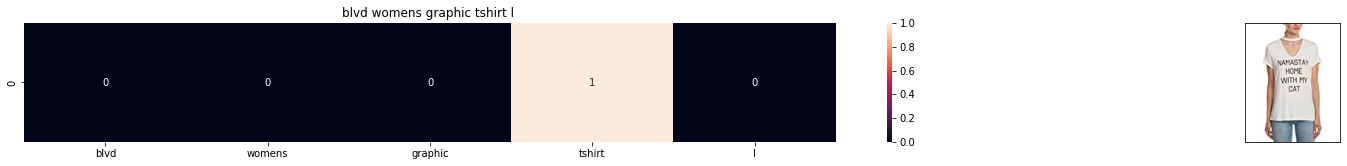

ASIN : B0733R2CJK
Brand: BLVD
Title: blvd womens graphic tshirt l 
Euclidean similarity with the query image : 3.1622776601683795


In [36]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(12566, 10) # change the index if you want to.
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.

#try 12566
#try 931

## TF-IDF based product similarity

In [26]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])


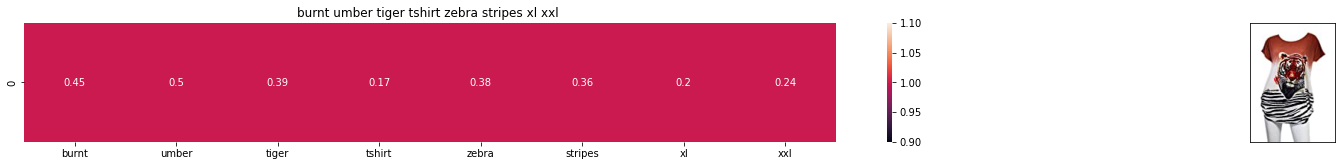

ASIN : B00JXQB5FQ
BRAND : Si Row
Eucliden distance from the given image : 0.0


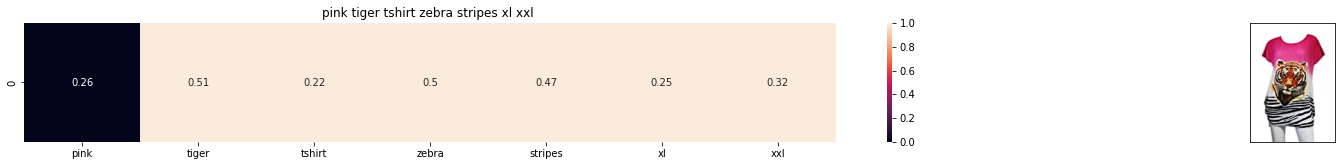

ASIN : B00JXQASS6
BRAND : Si Row
Eucliden distance from the given image : 0.7536331912451363


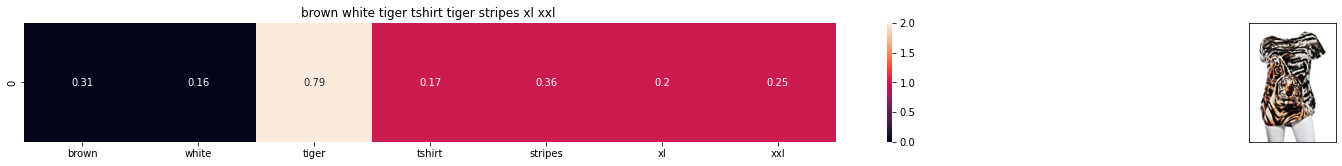

ASIN : B00JXQCWTO
BRAND : Si Row
Eucliden distance from the given image : 0.9357643943769647


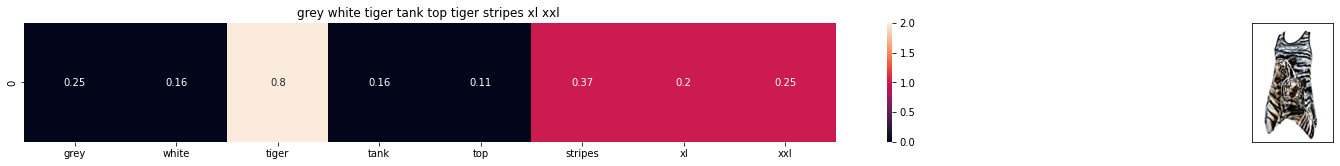

ASIN : B00JXQAFZ2
BRAND : Si Row
Eucliden distance from the given image : 0.9586153524200749


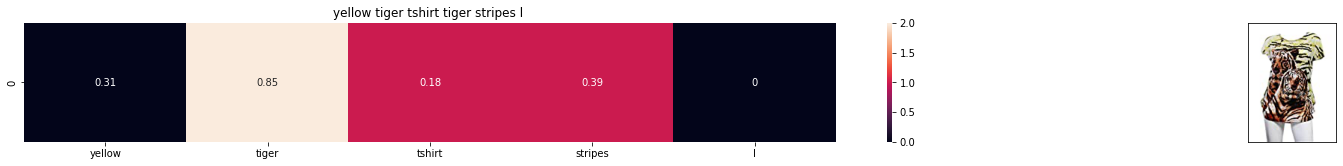

ASIN : B00JXQCUIC
BRAND : Si Row
Eucliden distance from the given image : 1.000074961446881


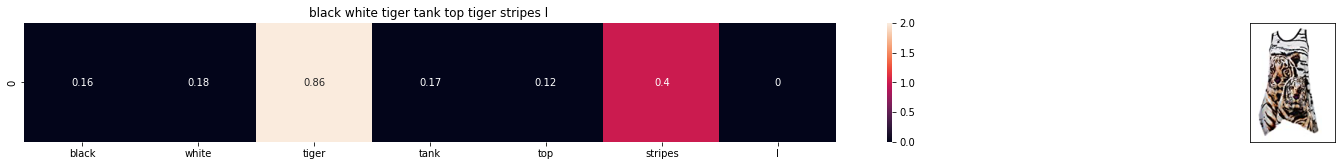

ASIN : B00JXQAO94
BRAND : Si Row
Eucliden distance from the given image : 1.023215552457452


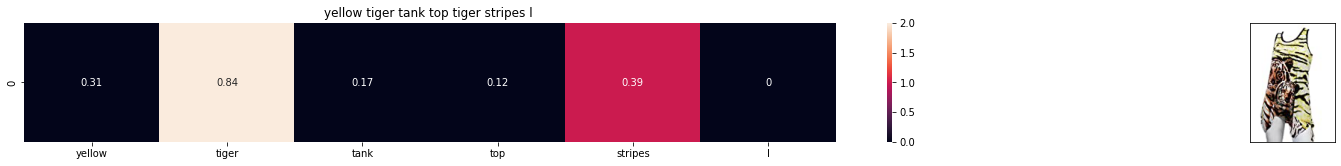

ASIN : B00JXQAUWA
BRAND : Si Row
Eucliden distance from the given image : 1.031991846303421


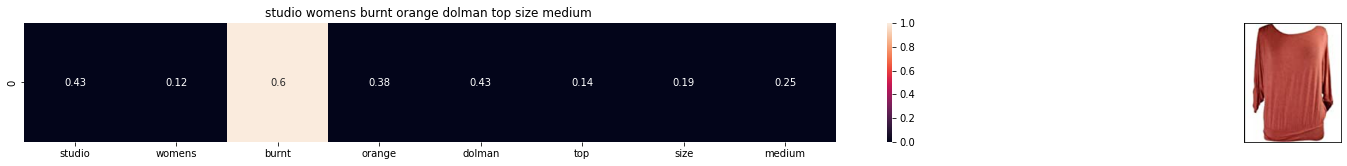

ASIN : B06XSCVFT5
BRAND : Studio M
Eucliden distance from the given image : 1.2106843670424716


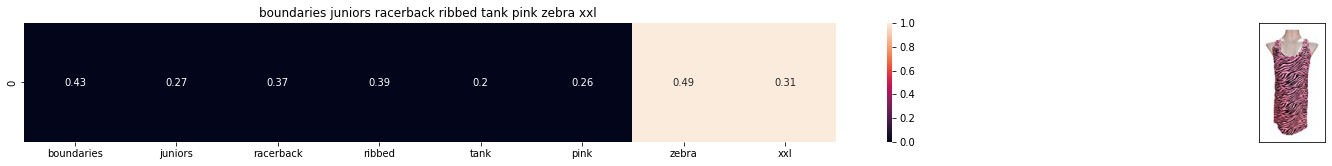

ASIN : B06Y2GTYPM
BRAND : No Boundaries
Eucliden distance from the given image : 1.2121683810720831


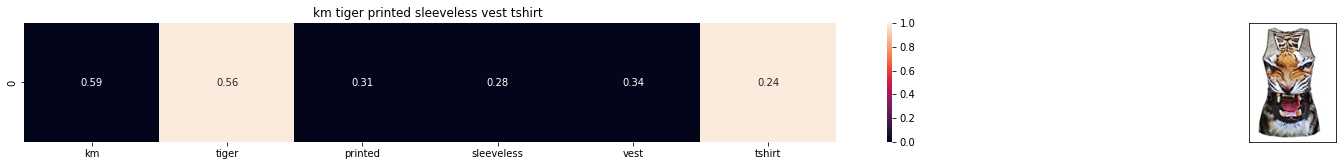

ASIN : B012VQLT6Y
BRAND : KM T-shirt
Eucliden distance from the given image : 1.219790640280982


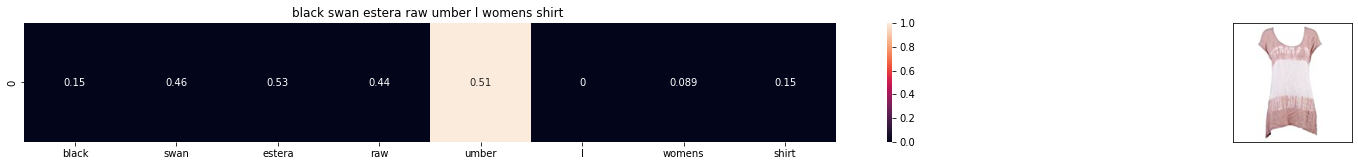

ASIN : B06Y1VN8WQ
BRAND : Black Swan
Eucliden distance from the given image : 1.2206849659998316


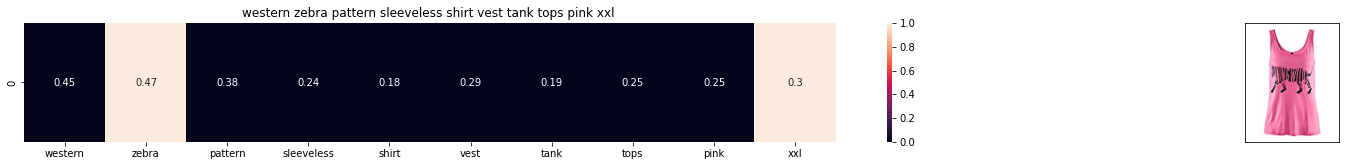

ASIN : B00Z6HEXWI
BRAND : Black Temptation
Eucliden distance from the given image : 1.221281392120943


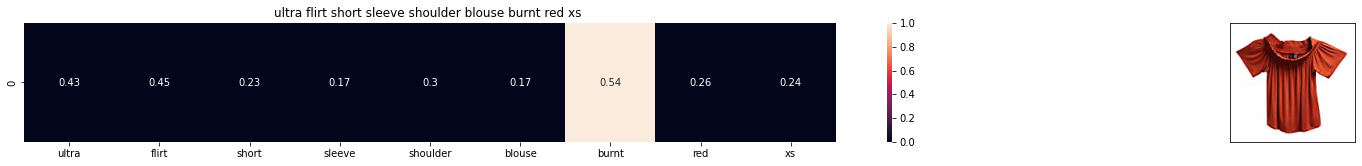

ASIN : B074TR12BH
BRAND : Ultra Flirt
Eucliden distance from the given image : 1.2313364094597743


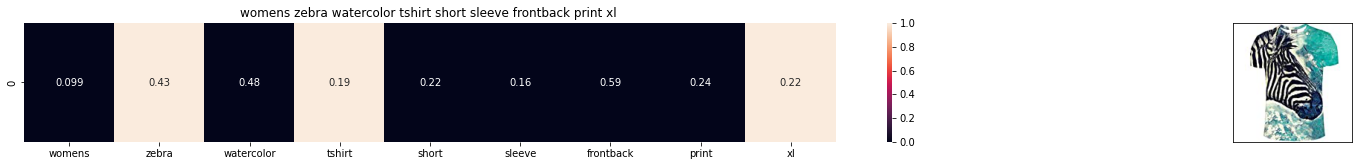

ASIN : B072R2JXKW
BRAND : WHAT ON EARTH
Eucliden distance from the given image : 1.2318451972624516


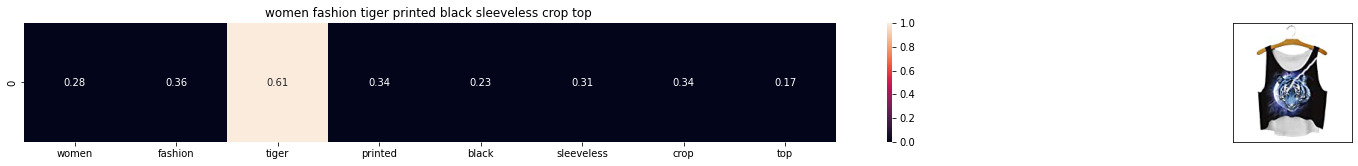

ASIN : B074T8ZYGX
BRAND : MKP Crop Top
Eucliden distance from the given image : 1.2340607457359425


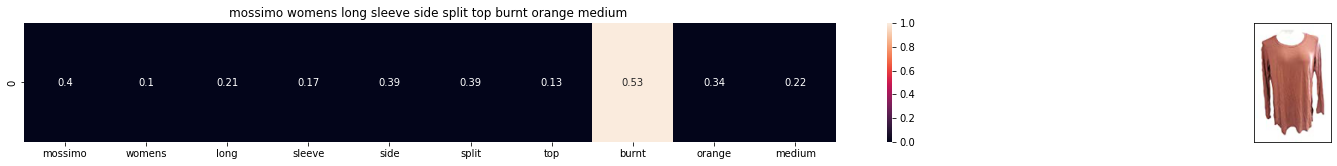

ASIN : B071ZDF6T2
BRAND : Mossimo
Eucliden distance from the given image : 1.2352785577664824


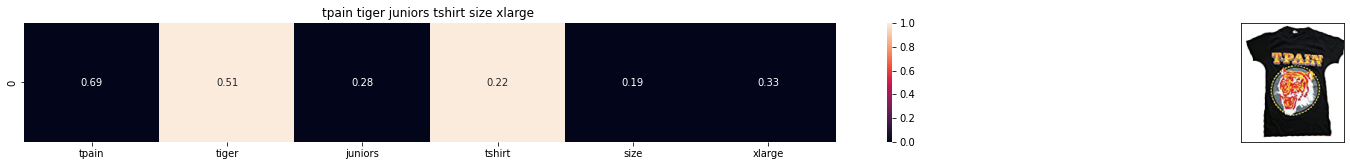

ASIN : B01K0H02OG
BRAND : Tultex
Eucliden distance from the given image : 1.236457298812782


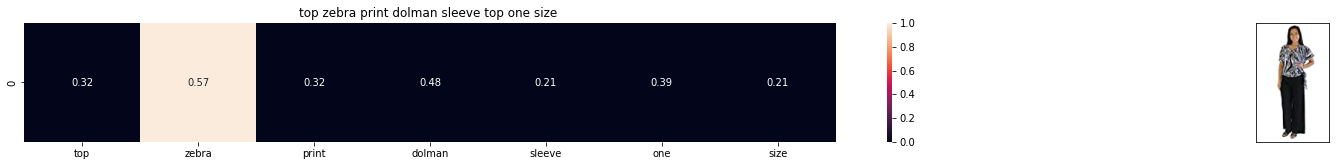

ASIN : B00H8A6ZLI
BRAND : Vivian's Fashions
Eucliden distance from the given image : 1.24996155052848


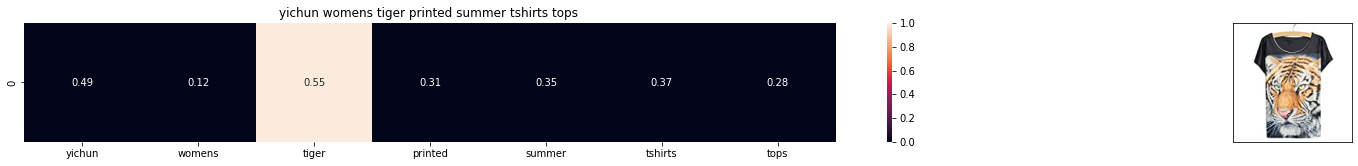

ASIN : B010NN9RXO
BRAND : YICHUN
Eucliden distance from the given image : 1.2535461420856102


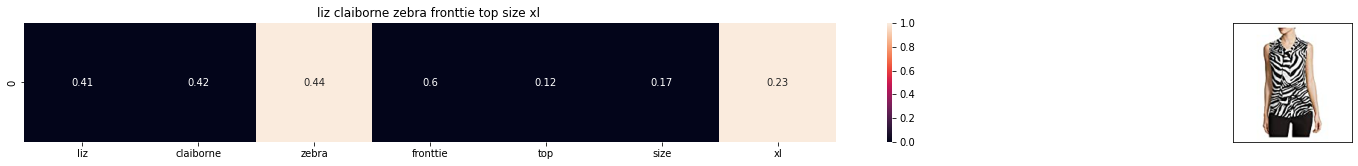

ASIN : B06XBY5QXL
BRAND : Liz Claiborne
Eucliden distance from the given image : 1.2538832938357722


In [37]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title

##IDF based product similarity

In [31]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])


In [32]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [33]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

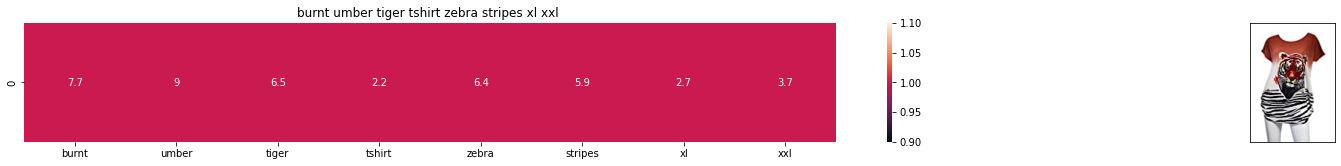

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from the given image : 0.0


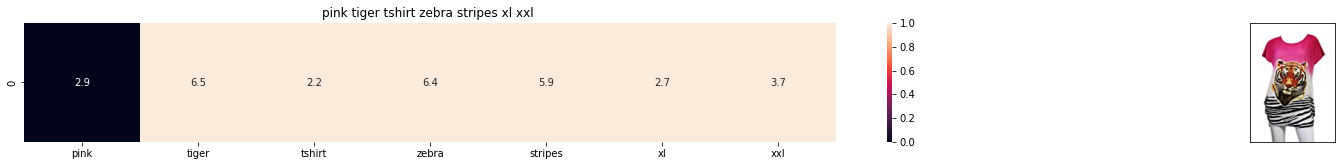

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from the given image : 12.20507131122177


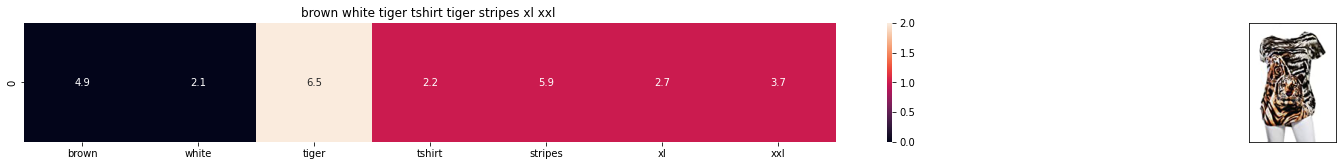

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from the given image : 14.468362685603465


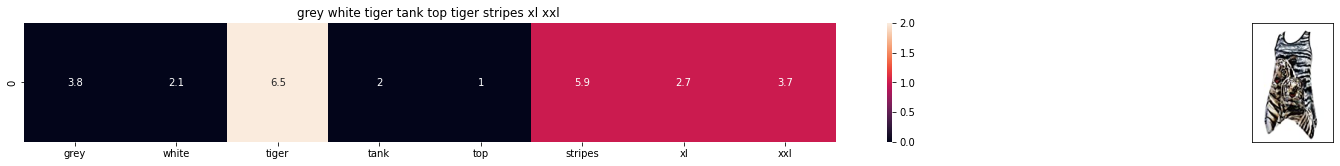

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from the given image : 14.486832924778964


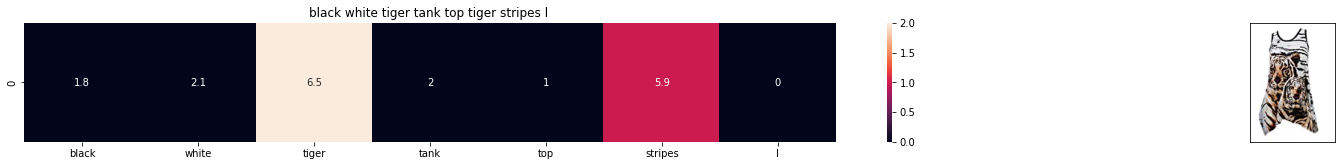

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from the given image : 14.833392966672909


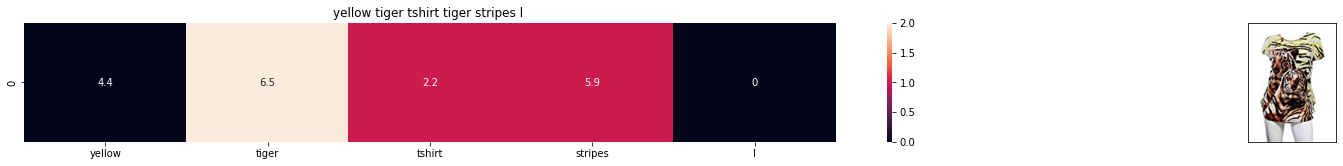

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from the given image : 14.898744516719225


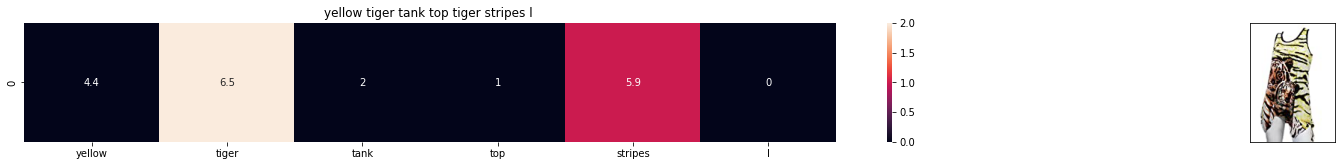

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from the given image : 15.224458287343769


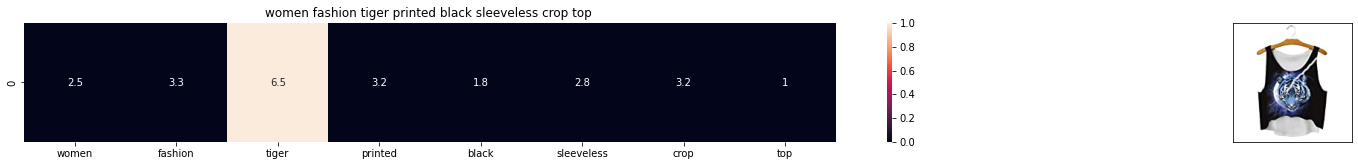

ASIN : B074T8ZYGX
Brand : MKP Crop Top
euclidean distance from the given image : 17.080812955631995


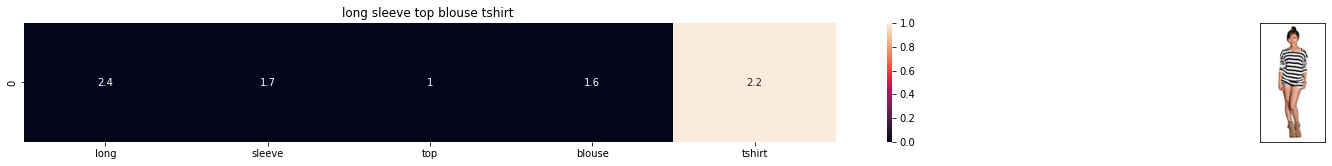

ASIN : B00KF2N5PU
Brand : Vietsbay
euclidean distance from the given image : 17.090168125645416


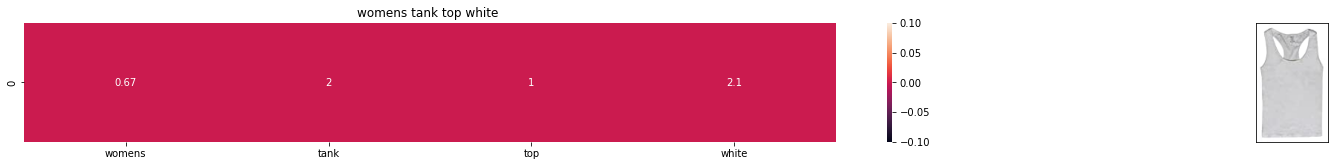

ASIN : B00JPOZ9GM
Brand : Sofra
euclidean distance from the given image : 17.153215337562703


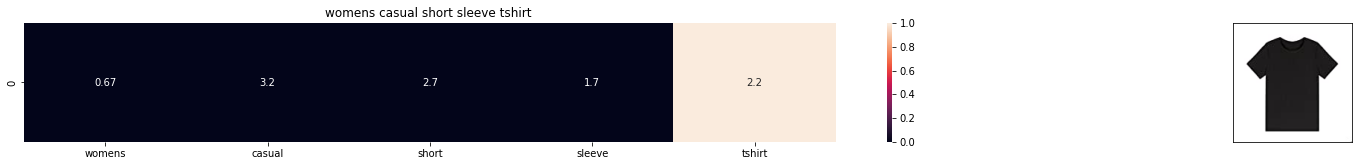

ASIN : B074T9KG9Q
Brand : Rain
euclidean distance from the given image : 17.33671523874989


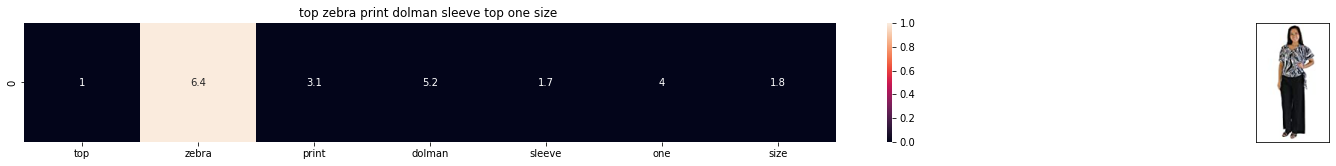

ASIN : B00H8A6ZLI
Brand : Vivian's Fashions
euclidean distance from the given image : 17.410075941001253


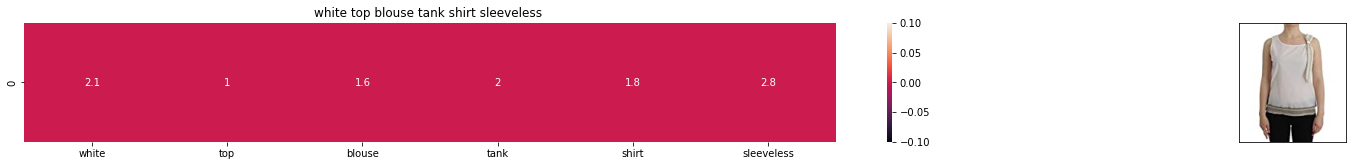

ASIN : B074G5G5RK
Brand : ERMANNO SCERVINO
euclidean distance from the given image : 17.539921335459557


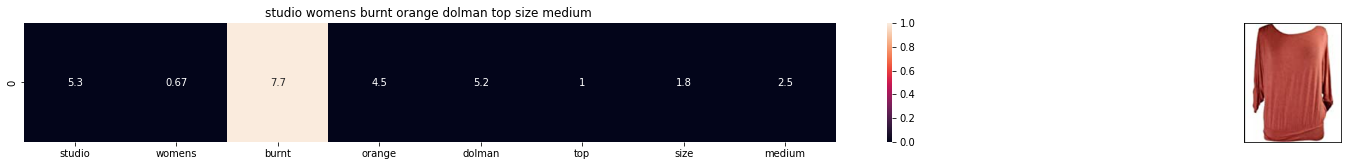

ASIN : B06XSCVFT5
Brand : Studio M
euclidean distance from the given image : 17.61275854366134


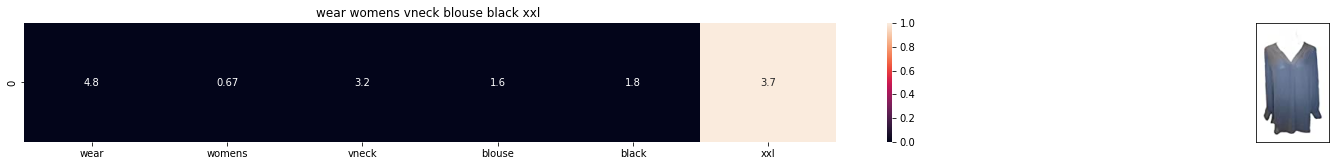

ASIN : B06Y6FH453
Brand : Who What Wear
euclidean distance from the given image : 17.623745282500135


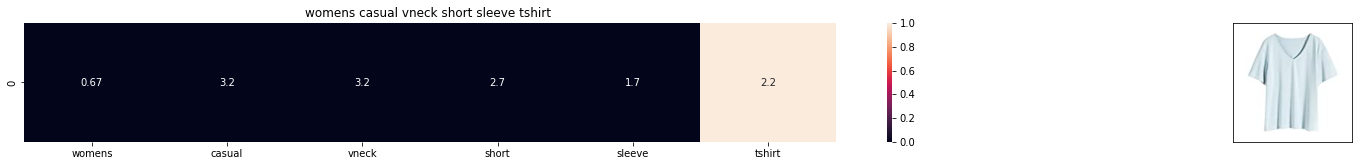

ASIN : B074V45DCX
Brand : Rain
euclidean distance from the given image : 17.634342496835046


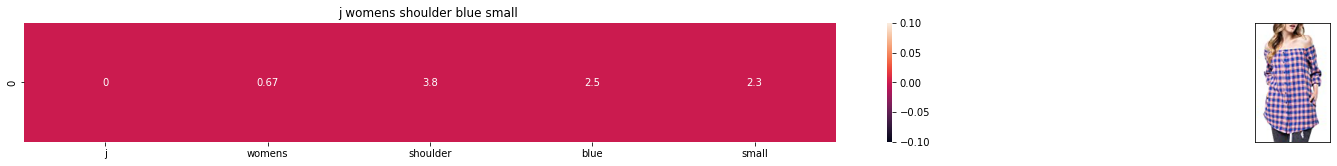

ASIN : B07583CQFT
Brand : Very J
euclidean distance from the given image : 17.63753712743611


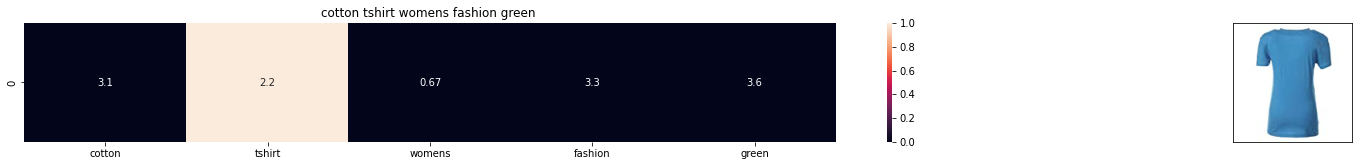

ASIN : B073GJGVBN
Brand : Ivan Levi
euclidean distance from the given image : 17.7230738913371


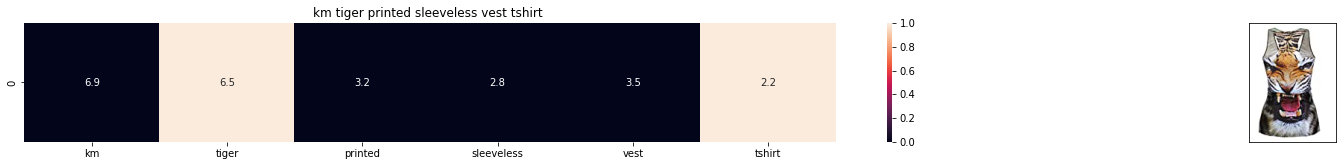

ASIN : B012VQLT6Y
Brand : KM T-shirt
euclidean distance from the given image : 17.762588561202364


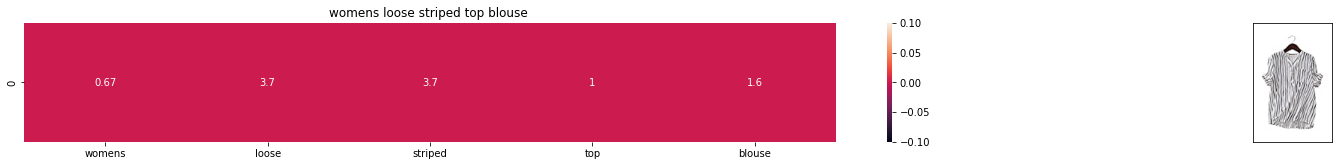

ASIN : B00ZZMYBRG
Brand : HP-LEISURE
euclidean distance from the given image : 17.779536864674238


In [34]:
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(12566,20)
# in the output heat map each value represents the idf values of the label word, the color represents the intersection with inputs title

#  Text Semantics based product similarity

In [2]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

'''
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
'''

#if you do NOT have RAM >= 12GB, use the code below.
with open('/content/drive/MyDrive/Colab_Notebooks/Case_Studies/amazon_recommander_system/word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [3]:
# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [4]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

###  Average Word2Vec product similarity.

In [7]:
doc_id = 0
w2v_title = []
# for every title we build a avg vector representation
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)


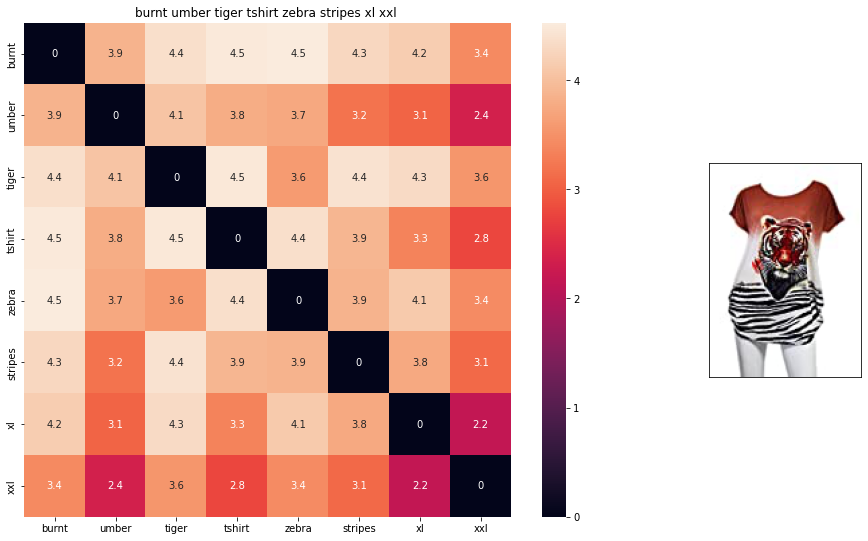

ASIN : B00JXQB5FQ
BRAND : Si Row
euclidean distance from given input image : 0.0


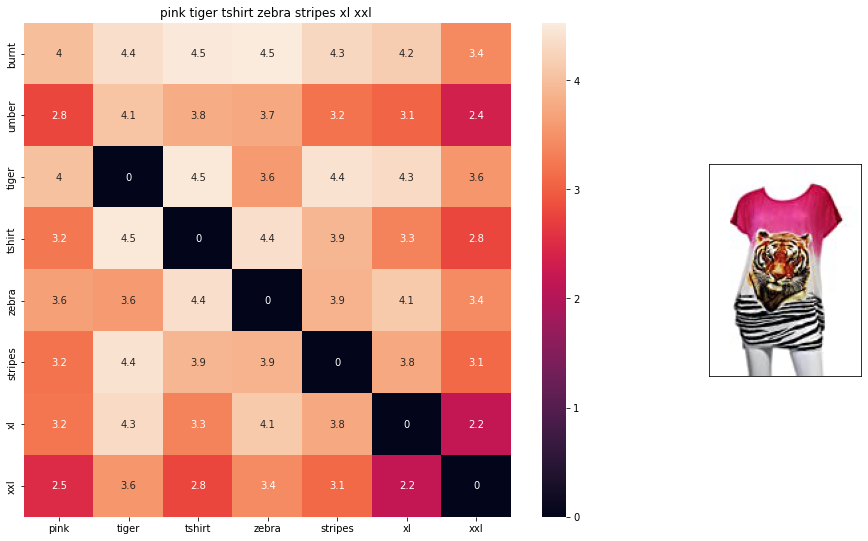

ASIN : B00JXQASS6
BRAND : Si Row
euclidean distance from given input image : 0.5891926


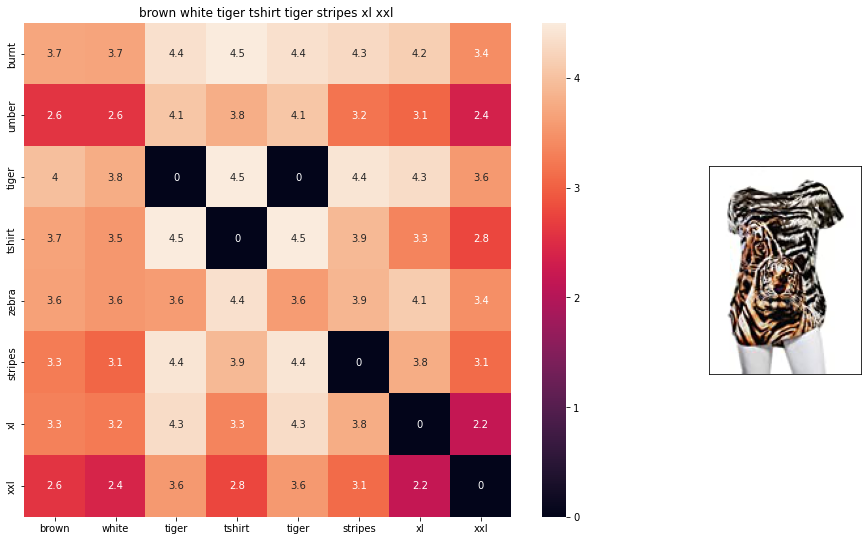

ASIN : B00JXQCWTO
BRAND : Si Row
euclidean distance from given input image : 0.7003438


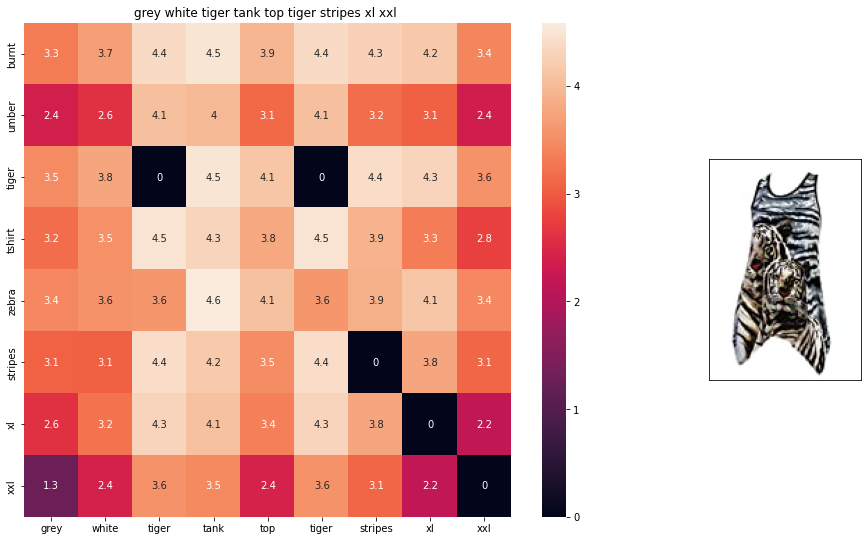

ASIN : B00JXQAFZ2
BRAND : Si Row
euclidean distance from given input image : 0.89283955


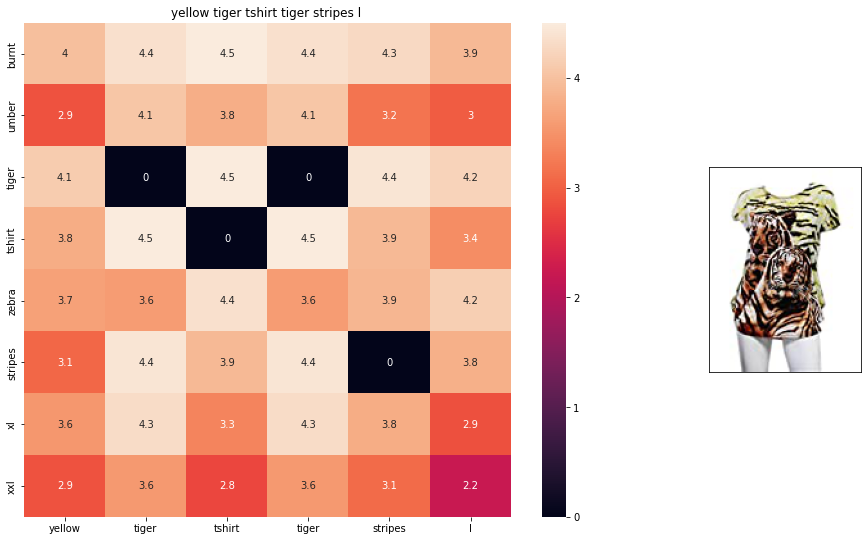

ASIN : B00JXQCUIC
BRAND : Si Row
euclidean distance from given input image : 0.95601255


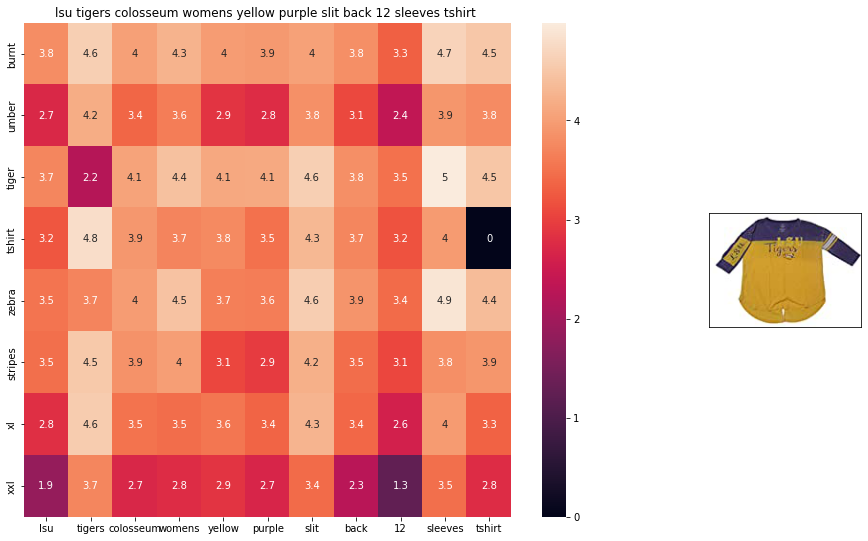

ASIN : B073R5Q8HD
BRAND : Colosseum
euclidean distance from given input image : 1.022969


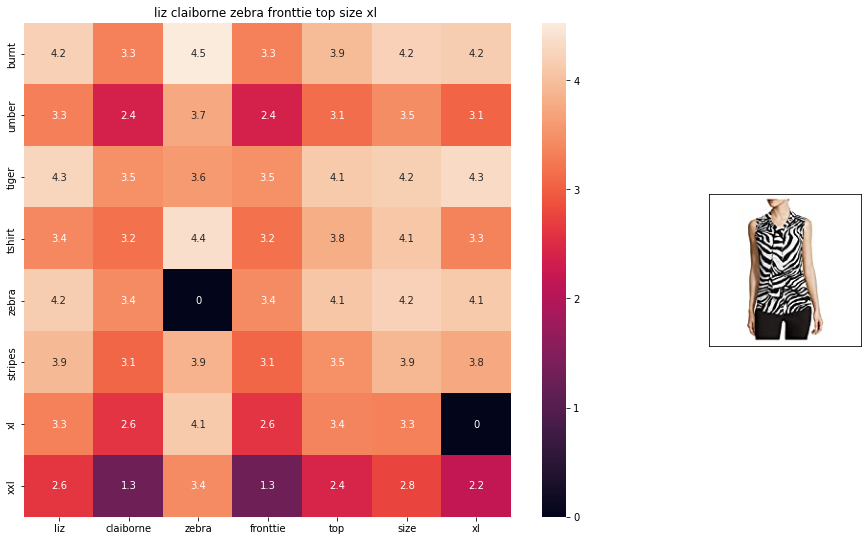

ASIN : B06XBY5QXL
BRAND : Liz Claiborne
euclidean distance from given input image : 1.0669324


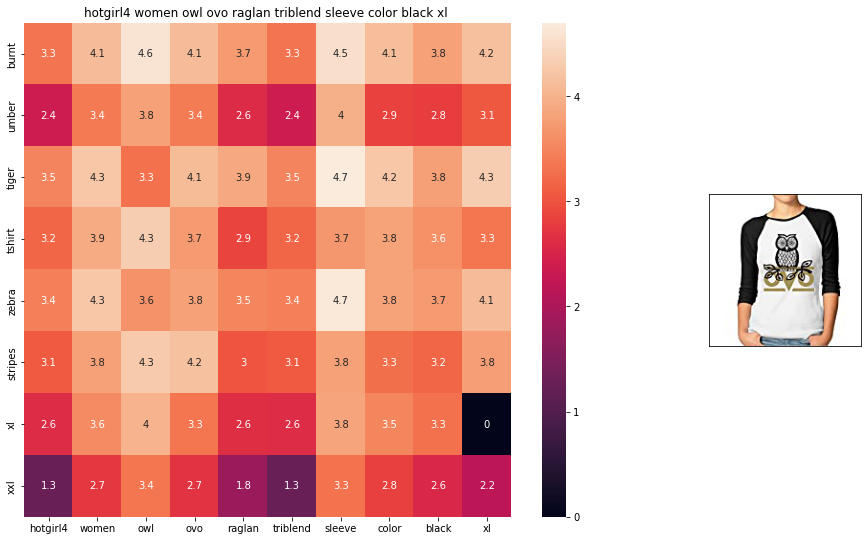

ASIN : B01L8L73M2
BRAND : Hotgirl4 Raglan Design
euclidean distance from given input image : 1.0731405


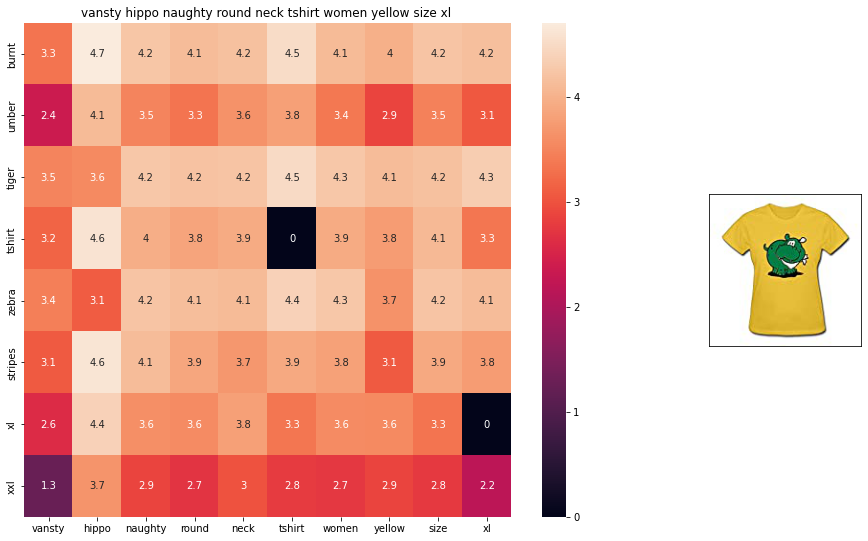

ASIN : B01EJS5H06
BRAND : Vansty
euclidean distance from given input image : 1.075719


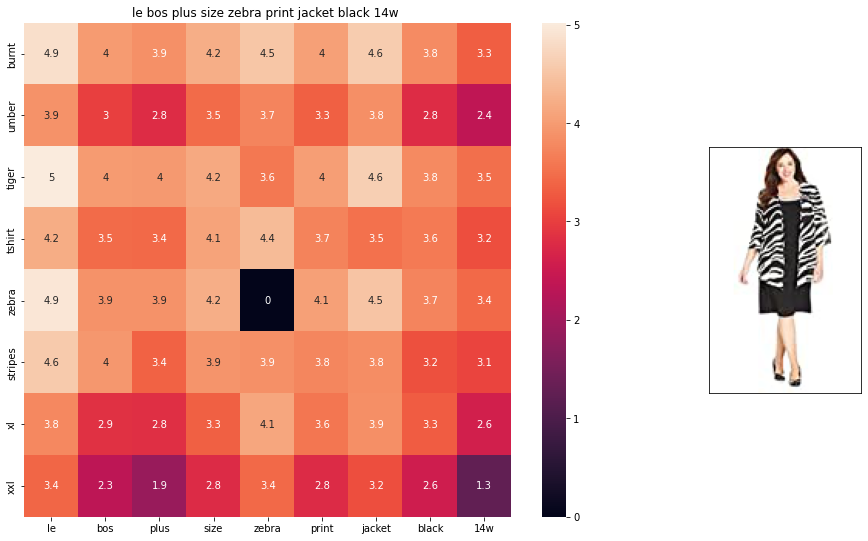

ASIN : B01BO1XRK8
BRAND : Le Bos
euclidean distance from given input image : 1.0839964


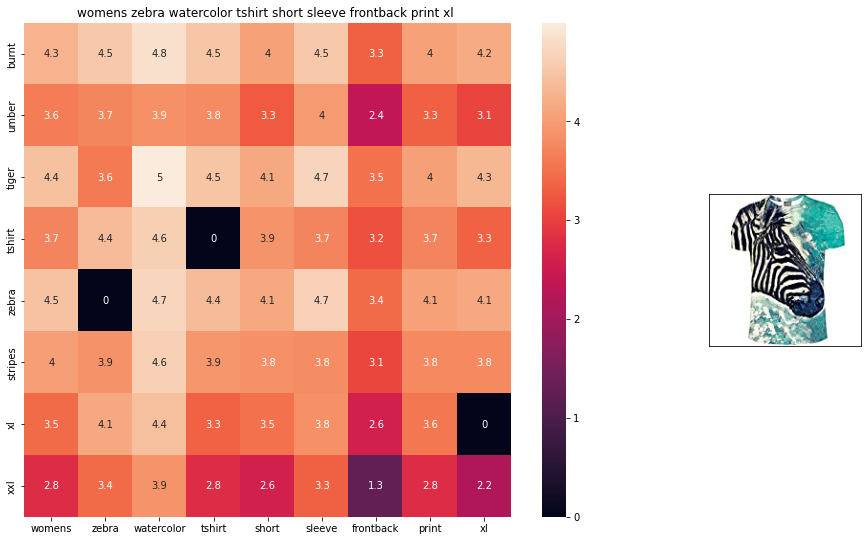

ASIN : B072R2JXKW
BRAND : WHAT ON EARTH
euclidean distance from given input image : 1.0842218


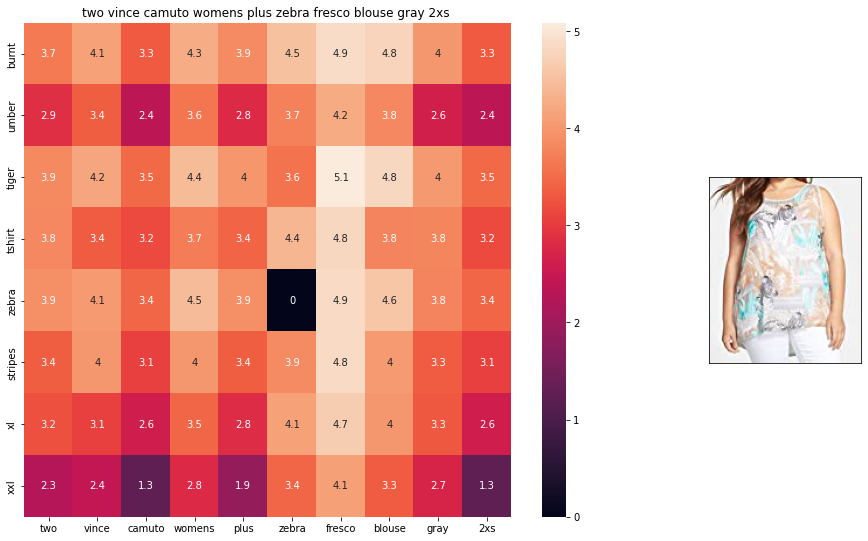

ASIN : B074MJRGW6
BRAND : Two by Vince Camuto
euclidean distance from given input image : 1.0895038


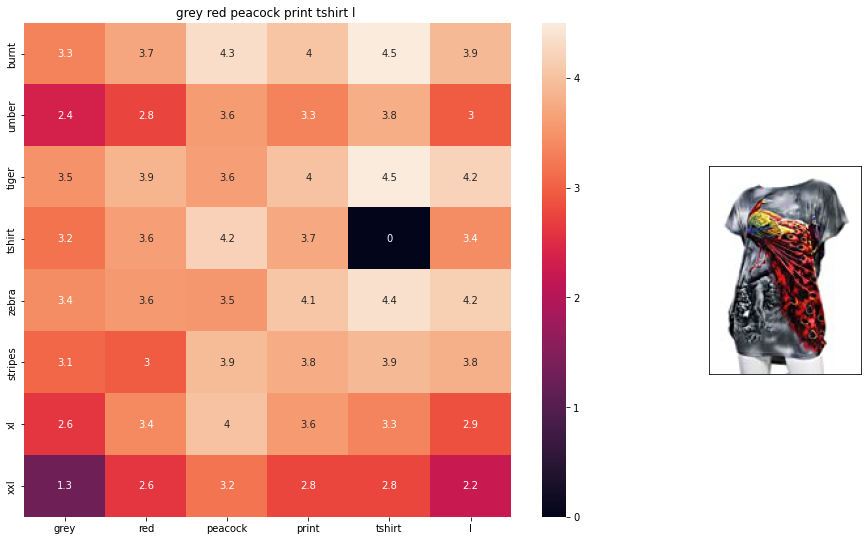

ASIN : B00JXQCFRS
BRAND : Si Row
euclidean distance from given input image : 1.0900588


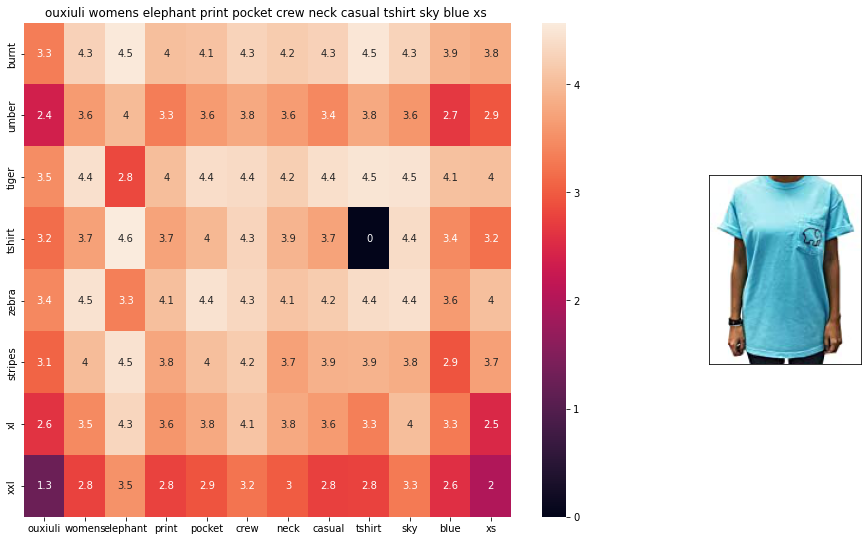

ASIN : B01I53HU6K
BRAND : ouxiuli
euclidean distance from given input image : 1.0920111


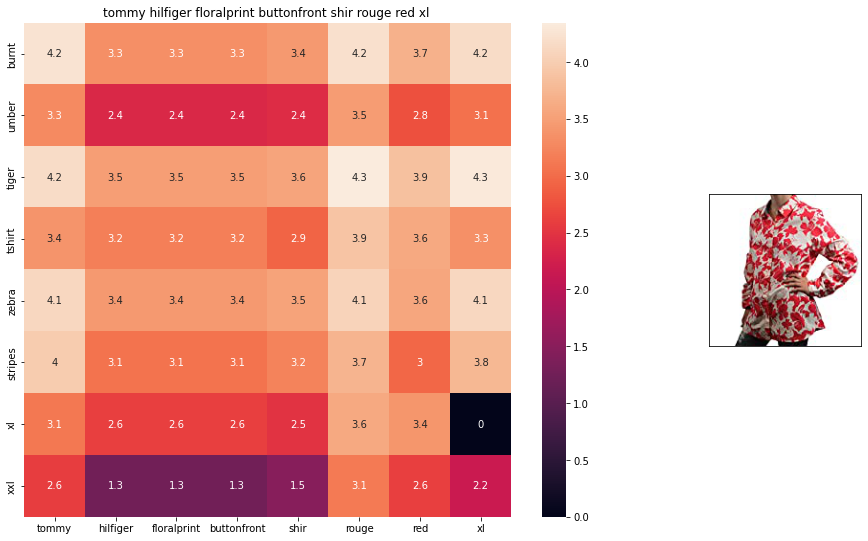

ASIN : B0711NGTQM
BRAND : THILFIGER RTW
euclidean distance from given input image : 1.0923415


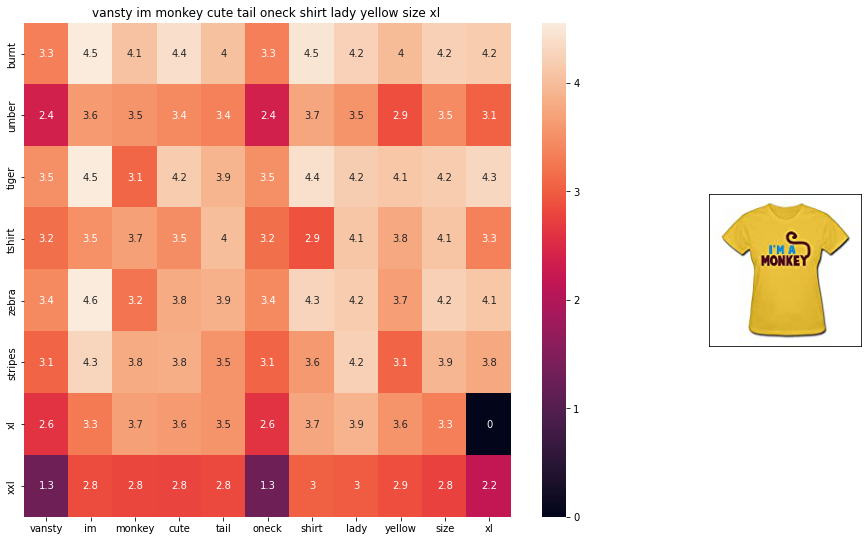

ASIN : B01EFSLO8Y
BRAND : Vansty
euclidean distance from given input image : 1.0934004


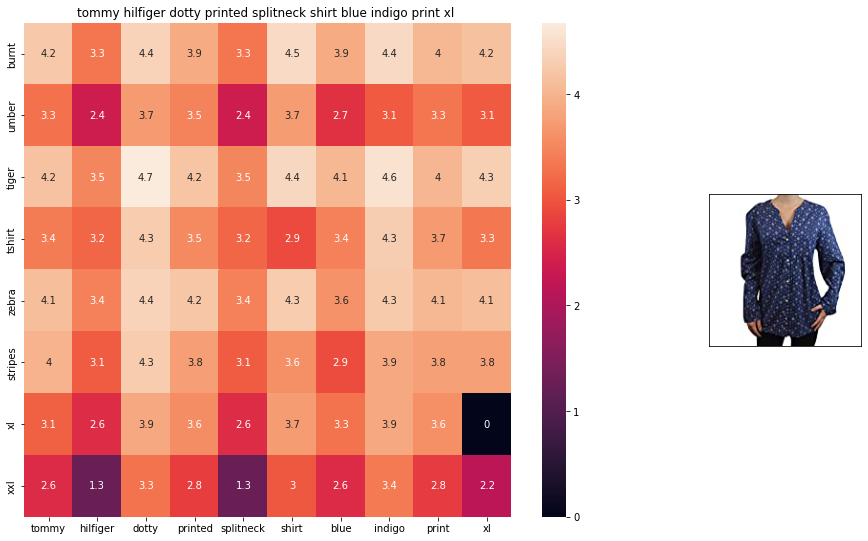

ASIN : B0716TVWQ4
BRAND : THILFIGER RTW
euclidean distance from given input image : 1.0942024


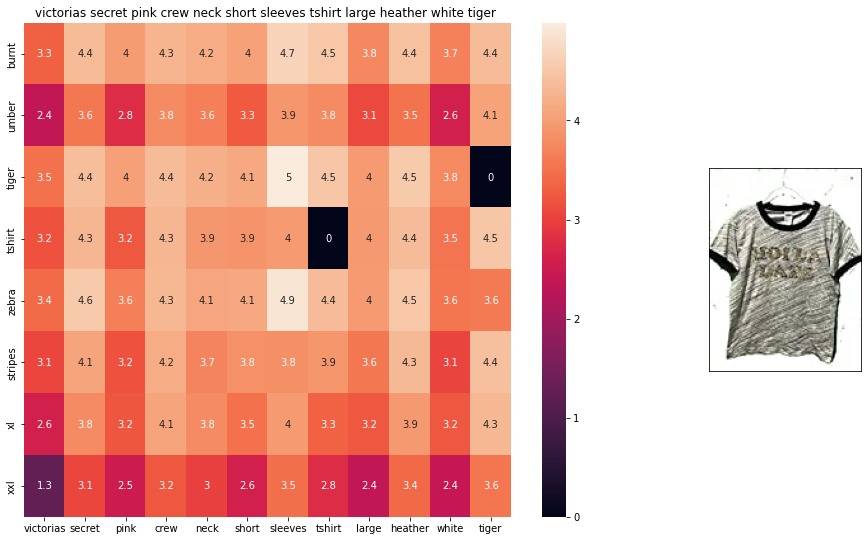

ASIN : B0716MVPGV
BRAND : V.Secret
euclidean distance from given input image : 1.0948304


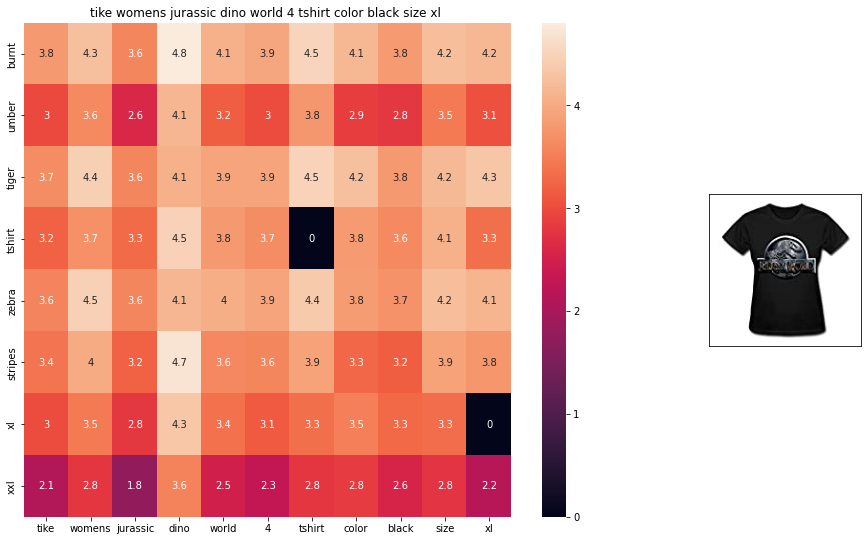

ASIN : B016OPN4OI
BRAND : TIKE Fashions
euclidean distance from given input image : 1.0951275


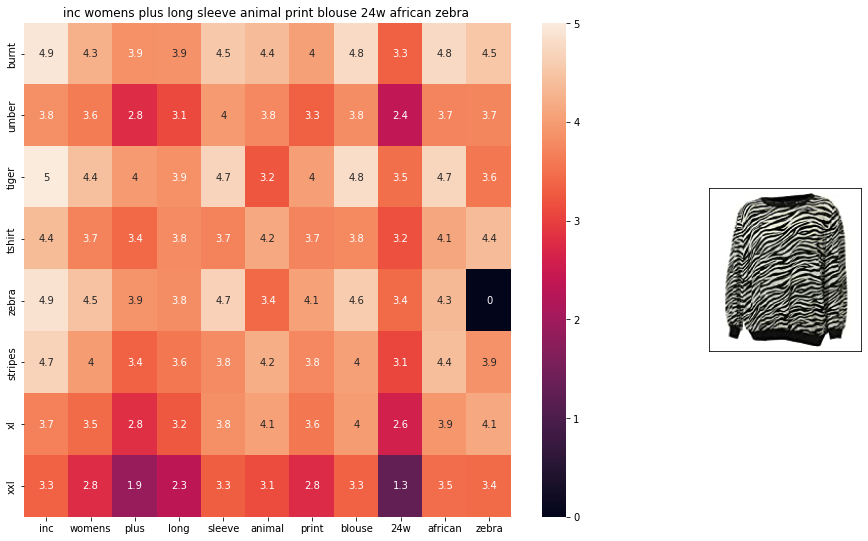

ASIN : B018WDJCUA
BRAND : INC - International Concepts Woman
euclidean distance from given input image : 1.0966892


In [10]:
def avg_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)

        
avg_w2v_model(12566, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j